## q<sup>2</sup> Tutorial - 1. Introduction

Welcome to the q<sup>2</sup> Python package!

*Before you begin this Tutorial, make sure that you have MOOGSILENT installed; it is assumed that you have some experience using <a href="http://www.as.utexas.edu/~chris/moog.html">MOOG</a>. If you are not familiar with Python, know that this package has a number of dependencies such as numpy, scipy, matplotlib, and bokeh. The easiest way to satisfy all these requirements is to install the <a href="https://www.continuum.io/downloads">Anaconda</a> Python distribution. Also, it is best to follow this Tutorial on an IPython notebook. Finally, you should have the directory in which q<sup>2</sup> is located in your PYTHONPATH environment variable.*

Begin by importing the q<sup>2</sup> package:

In [1]:
import q2

For any given q<sup>2</sup> project, two csv (comma-separated-values) files are required: one with star data such as Teff, logg, etc., and another one with spectral line data, i.e., a line list with atomic data and measured equivalent widths (EWs).

Take a look at the two files used in this example: "standard_stars.csv" and "standards_lines.csv", to have an idea of the format (you should be able to open these files with MS Excel, LibreOffice, or any text editor). Column order is not important, but a few columns are required: id, teff, logg, feh, and vt in the "stars" file, and wavelength, species, ep, and gf in the "lines" file. The EWs should be given in the "lines" file with a column header corresponding to the id of the star.

Here, the data from the csv files are loaded into an object called data (nothing will happen to the csv files from now on; in fact, q<sup>2</sup> will never modify them):

In [2]:
data = q2.Data('standards_stars.csv', 'standards_lines.csv')

We can inspect our data by calling the object attributes "star_data" and "lines". For example, let's check the stars' ids, Teffs, and the first five EWs of the Sun (compare this output with the data in the csv files to understand what you are doing here):

In [3]:
print(data.star_data['id'])
print(data.star_data['teff'])
print(data.lines['Sun'][:5])

['Sun' 'Arcturus']
[5777 4286]
[ 29.   62.5  32.6  32.5  80. ]


To begin using q<sup>2</sup>'s tools we need to create Star objects (note that we create the star objects with the star's names as the first parameter and exacly as listed in the csv files, or the data object; if you create the star object with a star name that is not in the data object, e.g., "q2.Star('Sol')" or "q2.Star('arcturus')", q<sup>2</sup> will not be able to figure out what to do with that star):

In [4]:
sun = q2.Star('Sun')
arcturus = q2.Star('Arcturus')

print(sun)

Star object named 'Sun':
  Teff (K) = None, logg [cgs] = None, [Fe/H] = None, vt (km/s) = None
  Spectral lines = None (species: None)
  Model atmosphere: None


At this point, the sun object has no parameters, spectral lines, or a model atmosphere; it is just a bare star object (the same is true for arcturus).

To asign the attributes to these stars' objects we use the "get_data_from" method. Our csv files are no longer being used to get this information; the data object is instead employed for that:

In [5]:
sun.get_data_from(data)
arcturus.get_data_from(data)

print(sun)
print("")
print(arcturus)

Star object named 'Sun':
  Teff (K) = 5777, logg [cgs] = 4.44, [Fe/H] = 0.0, vt (km/s) = 0.97
  Spectral lines = 46 (species: 26.0,26.1)
  Model atmosphere: None

Star object named 'Arcturus':
  Teff (K) = 4286, logg [cgs] = 1.66, [Fe/H] = -0.52, vt (km/s) = 1.74
  Spectral lines = 46 (species: 26.0,26.1)
  Model atmosphere: None


Since we also uploaded a master line list (the "lines" csv file), the star objects now also have their own linelist data. These data were also asigned by the "get_data_from" method. We can inspect these linelist details as follows:

In [6]:
print("Wavelength column (first five):")
print(sun.linelist['wavelength'][:5])
print("Equivalent width column (first five):")
print(sun.linelist['ew'][:5])

Wavelength column (first five):
[ 5295.3101  5379.5698  5386.3301  5441.3398  5638.2598]
Equivalent width column (first five):
[ 29.   62.5  32.6  32.5  80. ]


Our stars have all fundamental atmospheric parameters defined (they can be input guess values at this point). Therefore, we can use the "get_model_atmosphere" method to look for models or interpolate them from the available grids. Here we will use MARCS models, hence the 'marcs' argument that is passed to this method. For Kurucz models we can use 'odfnew' (the default), 'aodfnew', 'over', or 'nover'.

In [7]:
sun.get_model_atmosphere('marcs')
arcturus.get_model_atmosphere('marcs')

print(sun)

Star object named 'Sun':
  Teff (K) = 5777, logg [cgs] = 4.44, [Fe/H] = 0.0, vt (km/s) = 0.97
  Spectral lines = 46 (species: 26.0,26.1)
  Model atmosphere: marcs


We just added an attribute model_atmosphere to our star objects sun and arcturus. At any point, we can check what grid the model attached to a given Star object was taken or interpolated from by looking at the model_atmosphere_grid attribute (or just by printing the object as done above for sun). The code below makes the classic RHOX vs T graph (after importing matplotlib; the "%matplotlib inline" command allows the images created by q<sup>2</sup> to be shown on the IPython notebook):

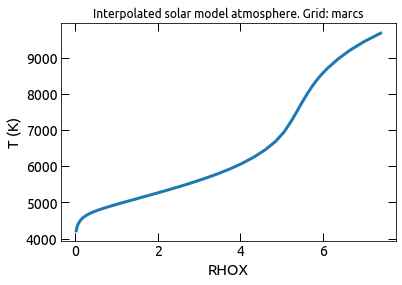

In [8]:
import matplotlib.pylab as plt
%matplotlib inline

plt.plot(sun.model_atmosphere['RHOX'], sun.model_atmosphere['T'])
plt.xlabel("RHOX")
plt.ylabel("T (K)")
plt.title("Interpolated solar model atmosphere. Grid: {}".\
          format(sun.model_atmosphere_grid));

Note that the "model_atmosphere" attribute/dictionary has all the necessary physical information to run a MOOG abfind calculation (and our star objects have the linelist data as well). The q2.moog module can help us create input files for a typical MOOG abfind run:

In [9]:
md = q2.moog.Driver()
md.create_file() #Creates a simple MOOGSILENT abfind driver
q2.moog.create_model_in(sun) #creates the model atmosphere file
q2.moog.create_lines_in(sun); #creates the linelist file

Have a look at the files you just created and inspect them. The files created (batch.par, model.in, lines.in) should have the familiar MOOG formats. At this point, you could go to your terminal and run MOOGSILENT (or MOOG and then enter batch.par as the driver). Of course, it is not terribly helpful if we are still going to have to call MOOG manually from the terminal. Instead, we can use q<sup>2</sup>'s "moog.abfind" function to calculate abundances running MOOG under the hood (let's keep our fingers crossed; this is when q<sup>2</sup> actually talks to MOOG!). In this example, we are computing line-by-line "FeII abundances" for the Sun:

In [10]:
q2.moog.abfind(sun, 26.1, 'fe2')
print(sun.fe2.keys())
print(sun.fe2['ww'])
print(sun.fe2['ab'])

dict_keys(['ww', 'ep', 'ew', 'rew', 'ab', 'difab'])
[ 4576.333  4620.513  5234.624  5264.804  5414.072  5425.257  6369.462
  6432.676  6516.077]
[ 7.354  7.283  7.319  7.451  7.432  7.413  7.402  7.424  7.456]


The "moog.abfind" function ran MOOGSILENT for us, creating the MOOG input files and deleting them when done (all within a hidden folder .q2). The sun object in this example now has an fe2 attribute, which is a dictionary containing the MOOG outputs: ww=wavelength, ab=abundance, etc.

A common exercise in stellar spectroscopy is to derive iron abundances from FeI and FeII lines separately, in addition to calculating some statistics like abundance versus EP or REW slopes. This can be done with the "specpars" module as follows:

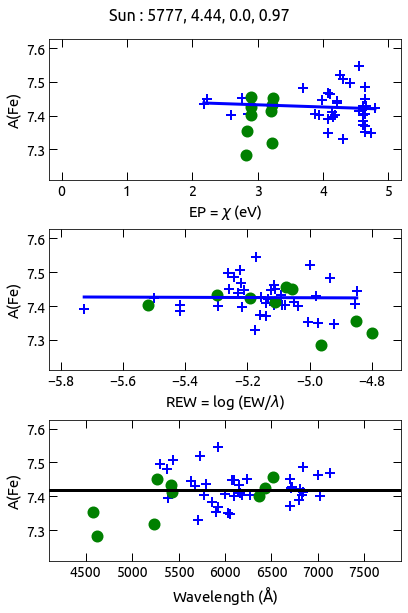

In [11]:
q2.specpars.iron_stats(sun, plot='sun')

The q2.specpars.iron_stats function makes a figure with the standard abundance versus EP/REW/wavelength plots. Look for the "sun.png" file for a hardcopy of this figure; the name of this file is set by the "plot" argument. In the figure, blue crosses are the FeI lines and green circles are the FeII lines. The solid blue lines are linear fits to the FeI data and the black line in the bottom panel is a horizontal line at the average value of the iron abundance.

The sun object now has an "iron_stats" attribute with the results of this calculation, so we can use them for further analysis. For example, let's have a look at the important results from the calculation above, namely average iron abundances from FeI and FeII lines and the EP/REW slopes:

In [12]:
print("A(Fe I)  = {0:5.3f} +/- {1:5.3f}".\
      format(sun.iron_stats['afe1'], sun.iron_stats['err_afe1']))
print("A(Fe II) = {0:5.3f} +/- {1:5.3f}".\
      format(sun.iron_stats['afe2'], sun.iron_stats['err_afe2']))
print("A(FeI) vs. EP slope  = {0:.4f} +/- {1:.4f}".\
      format(sun.iron_stats['slope_ep'], sun.iron_stats['err_slope_ep']))
print("A(FeI) vs. REW slope = {0:.4f} +/- {1:.4f}".\
      format(sun.iron_stats['slope_rew'], sun.iron_stats['err_slope_rew']))

A(Fe I)  = 7.425 +/- 0.049
A(Fe II) = 7.393 +/- 0.061
A(FeI) vs. EP slope  = -0.0065 +/- 0.0119
A(FeI) vs. REW slope = -0.0030 +/- 0.0478


There is some flexibility to modify the plots generated by q<sup>2</sup> with a PlotPars object that we will call "pp" here. This object can be passed on to q2.specpars.iron_stats. For example, we can force the y-axis to go from 7.1 to 7.7 using the "afe" controller. We can also change the default title and add an inside title as shown below. You could use these options to get rid of the titles as well (e.g., pp.title = '', pp.title_inside = ''):

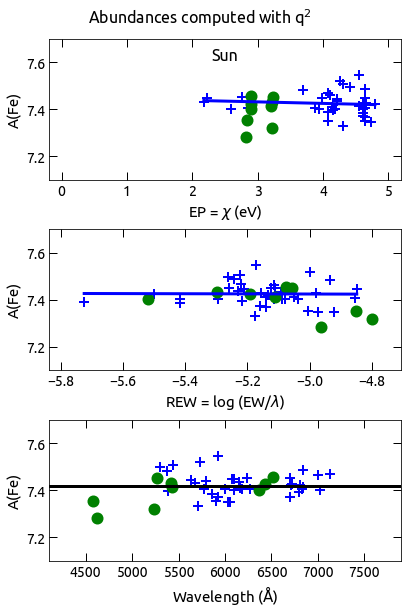

In [13]:
pp = q2.specpars.PlotPars()
pp.afe = [7.1, 7.7]
pp.title = 'Abundances computed with q$^2$'
pp.title_inside = 'Sun'
q2.specpars.iron_stats(sun, plot='sun', PlotPars=pp)

The pp.afe controller sets the range of the y-axis: [ymin, ymax]. However, when ymin is set to -1000, q<sup>2</sup> makes the y-axis centered around the derived mean iron abundance and extends it to +/-ymax. Next we are going to redo the plots above with the default PlotPars parameters, except that the y-axis range is set to +/-0.25 from the average iron abundance:

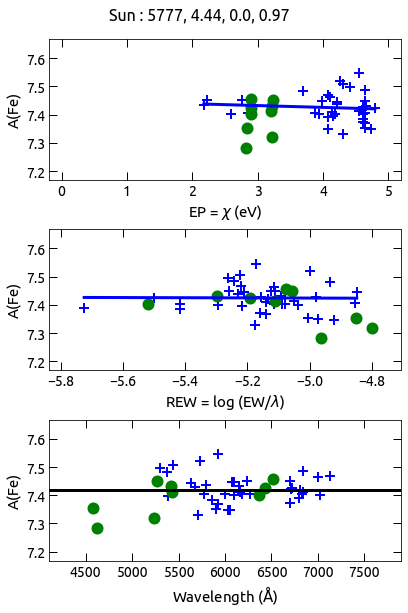

In [14]:
pp = q2.specpars.PlotPars()
pp.afe = [-1000, 0.25]
q2.specpars.iron_stats(sun, plot='sun', PlotPars=pp)

Let's do the same thing for Arcturus (note that we are controlling the plots' appearance with pp as well so they are consistent with the Sun's plots, particularly the y-axis range; look for the "arcturus.png" file after running this command):

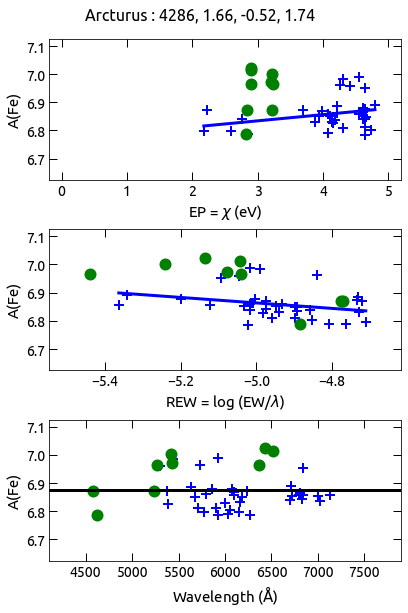

In [15]:
q2.specpars.iron_stats(arcturus, plot='arcturus', PlotPars=pp)

We have used q<sup>2</sup> to calculate "absolute" iron abundances of the Sun and Arcturus. Another common practice in this field is to compute "differential" abundances, i.e., abundances in a given problem star relative to a reference. In these cases, it is common to use the Sun as the reference star. 

To calculate differential abundances we can also use q2.specpars.iron_stats. For example, if we want to calculate the differential iron abundances of Arcturus relative to the Sun all we have to do is pass the object sun as Ref(erence):

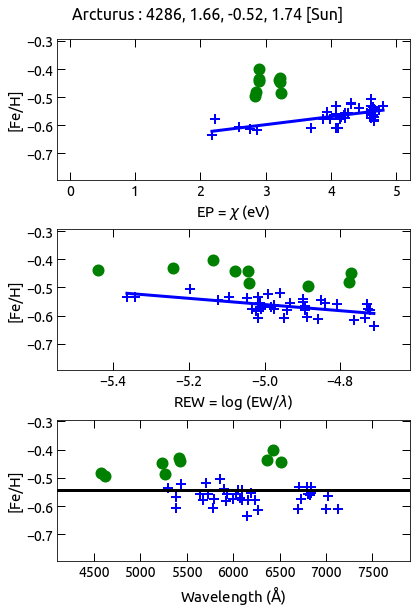

In [16]:
q2.specpars.iron_stats(arcturus, Ref=sun,
                       plot='arcturus_sun', PlotPars=pp)

This created a figure "arcturus_sun.png". Note that the y-axis label is not A(Fe), but [Fe/H], which is the standard notation for differential abundance.

Note that we didn't have to deal with the MOOG inputs or outputs, match line lists, create tables and do the statistics separately. All that was handled by q<sup>2</sup>. The single-line command above did the following:
- Created MOOG inputs for the Sun, ran MOOG, read the outputs, and attached the results to the sun object as sun.fe1, sun.fe2, and sun.iron_stats. Deleted the MOOG input and output files.
- Did the same thing for Arcturus.
- Matched the linelists of the Sun and Arcturus (sun.fe1 to arcturus fe1, etc.), subtracted the abundances measured on a line-by-line basis, and added a column "difab' to the arcturus.fe1 and arcturus.fe2 attributes, which contains these results.
- Calculated the slopes of 'difab' versus EP, REW and other common statistics.
- Made the figure.

Below we can see the abundances measured from FeII lines for Arcturus, first the absolute ones, and then the differential ones. You can always check what the reference star was to calculate those 'difab' values by looking at the 'reference' column of the iron_stats attribute:

In [17]:
print(arcturus.fe2['ab'])
print(arcturus.fe2['difab'])
print(arcturus.iron_stats['reference'])

[ 6.872  6.788  6.871  6.965  7.001  6.972  6.965  7.023  7.013]
[-0.482 -0.495 -0.448 -0.486 -0.431 -0.441 -0.437 -0.401 -0.443]
Sun


This concludes the Introduction. So far we have calculated iron abundances using input parameters as given in our csv files. As shown in the last figure we made, the iron abundances of Arcturus show trends with excitation potential and line-strength. Also, the mean FeI and FeII abundances are a bit different. This could be indicating that the input parameters used are not correct (within our 1D-LTE model assumptions). Let's move on to Part 2 of this Tutorial and use q<sup>2</sup> to derive "better" spectroscopic stellar parameters of stars.